# Experimental Settings

In [56]:
import time

# training dataset
labeled_data_size = 100
unlabeled_data_size = 2000

# training hyperparameter
num_train_epochs = 10

# dict_settings
dict_settings = {
    'labeled_data_size':labeled_data_size,
    'unlabeld_data_size':unlabeled_data_size,
    'num_train_epochs':num_train_epochs
}

print(dict_settings)

entire_notebook_t0 = time.time()

{'labeled_data_size': 100, 'unlabeld_data_size': 1000, 'num_train_epochs': 10}


# Using GPU

In [15]:
import tensorflow as tf

# Get the GPU device name.
device_name = tf.test.gpu_device_name()

# The device name should look like the following:
assert device_name == '/device:GPU:0'
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


In [16]:
# import package and torch
!pip install --upgrade packaging --quiet
!pip install torch --quiet

In [17]:
import torch

assert torch.cuda.is_available()

# Tell torch to use GPU
device = torch.device("cuda")
print('Running GPU: {}'.format(torch.cuda.get_device_name()))

Running GPU: GeForce GTX 1080 Ti


In [18]:
# import essential modules
import torch
import torch.nn.functional as F
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler

import random
import numpy as np
import pandas as pd

import time
import math
import datetime

In [19]:
# Set randon seed
seed = 1

random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)

# Prepare dataset

Convert dataset to a list of tuples: [(text, label) ... ]

1) 100 samples from each of 14 classes || 5.6k unlabeled data from the dataset


Number of different classes: 15


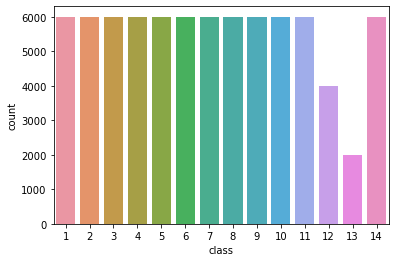

In [20]:
# Load training dataset
df = pd.read_csv('data/78k_without_punc.csv')

# Mapping the class to label code
# Label Encdoing
class_map={'UNK':0, '股票':1, '体育':2, '娱乐':3, '时政':4,
          '社会':5, '教育':6, '财经':7, '家居':8, '游戏':9,
          '房产':10, '时尚':11,'彩票':12, '星座':13, '科技':14}

# Show number of different classes
n_classes = len(class_map)
print('Number of different classes: {}'.format(n_classes))

# Mapping the class names
df['class'] = df['class'].map(class_map)

# Show class countplot
import seaborn as sns
sns.countplot(df['class'])

In [21]:
# Initaliza the first df
df_sampled = df[df['class']==1].sample(labeled_data_size)

# Import samples from the other classes
for i in range(2,15):
    df_temp = df[df['class'] == i].sample(labeled_data_size)
    df_sampled = pd.concat((df_sampled, df_temp))

Number of data entries: 1400


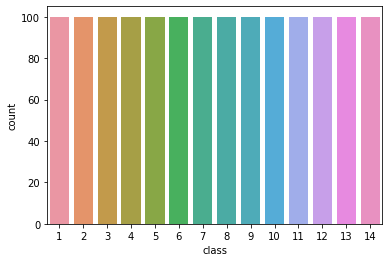

In [22]:
# Show class countplo
print('Number of data entries: {}'.format(len(df_sampled)))
sns.countplot(df_sampled['class'])

In [23]:
# Randomly choose 15k data entries which will be converted into unlabled data
df_unlabeled = df.sample(unlabeled_data_size)

# Convert class to UNK
df_unlabeled['class'] = 'UNK'

df_unlabeled

,text,class
6147,Ongamenet StarLeague专题回顾二 期回顾中讲述OSL发展历史对韩国全世界电...,UNK
60219,ESPN鹰王纯属鸡肋 送走扣篮王救命稻草 新浪体育讯北京时间8月9日过三年中亚特兰大老鹰队全...,UNK
53169,英国推出网络离婚计算器 指践踏婚姻制度 英国日邮报30日报道英国工党建立消费者金融教育机构C...,UNK
46243,申花客场平局扼杀金手指头奖--胜负彩035期对 北京时间04月08日中国足球彩票中国足球彩票...,UNK
52531,大宋豪侠新手攻略 话说大宋年间内奸臣道外强敌虎视值乱世三十六位义侠报效官府扮作卧底入大山寨七...,UNK
...,...,...
30088,08年12月英语六级A卷阅读答案沪江新东方 快速阅读1 C New explanation ...,UNK
36939,华侨城资产贬值2成 整体市临估价难题 吴丽娟/文年9月证监会没对市公司过会影响资本市场热捧华...,UNK
73126,军歌多嘹亮--招办主任解析军校报考新政策 话题 军校招生政策连线院校空军工程大学连线嘉宾贾贵...,UNK
63415,失恋女孩家中放火持刀威胁制止者 本报讯 前天晚南京秦淮区中桥路区房东报警说家房客女家中放火制...,UNK


In [24]:
# Split 20% of data from the df_sample as val_data
from sklearn.model_selection import train_test_split

df_labeled, df_val = train_test_split(df_sampled,
                                    test_size=0.2,
                                    random_state=1,
                                    stratify=df_sampled['class'])

for item in df_labeled, df_unlabeled, df_val:
    print(item.shape)

(1120, 2)
(2000, 2)
(280, 2)


/opt/conda/lib/python3.7/site-packages/sklearn/utils/__init__.py:806: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  return floored.astype(np.int)
/opt/conda/lib/python3.7/site-packages/sklearn/utils/__init__.py:806: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note

# Import BERT model

In [25]:
!pip install transformers --quiet

In [26]:
model_name = "bert-base-chinese"

from transformers import BertModel, BertTokenizer

# Load BERT tokenizer
transformer = BertModel.from_pretrained(model_name)
tokenizer = BertTokenizer.from_pretrained(model_name)

Some weights of the model checkpoint at bert-base-chinese were not used when initializing BertModel: ['cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


# Prepare dataloader

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Text(0.5, 1.0, 'df_val label mask')

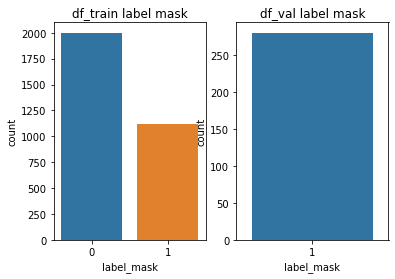

In [27]:
# Combine df_labeled and df_unlabeled into the train_dataloader
df_train = pd.concat((df_labeled, df_unlabeled))

# Convert UNK to class zero
df_train['class'] = df_train['class'].apply(lambda x: 0 if x=='UNK' else x)

# Create a new column for label_mask
def generate_label_mask(label):
    if label == 0:
        return 0
    else:
        return 1

df_train['label_mask'] = df_train['class'].apply(generate_label_mask)

# Show label_mask distribution
import matplotlib.pyplot as plt
plt.subplot(1,2,1)
sns.countplot(df_train['label_mask'])
plt.title('df_train label mask')

# Generate label mask for df_val
df_val['label_mask'] = df_val['class'].apply(generate_label_mask)

# Show label_mask distribution
plt.subplot(1,2,2)
sns.countplot(df_val['label_mask'])
plt.title('df_val label mask')


In [28]:
# Hyperparameteres
max_length = 128
batch_size = 32

# Tokenization and covnert dataframes to datasets
def encode_df(df):
    input_ids = []
    attention_mask = []
    texts = df['text'].values
    labels = df['class'].values
    label_masks = df['label_mask'].values
    
    for text in texts:
        encoded_dict = tokenizer.encode_plus(text,
                                             add_special_tokens=True,
                                             padding='max_length',
                                             return_attention_mask=True,
                                             max_length=max_length,
                                             return_tensors='pt',
                                             truncation=True)
        
        input_ids.append(encoded_dict['input_ids'])
        attention_mask.append(encoded_dict['attention_mask'])
    
    return input_ids, attention_mask, labels, label_masks

In [29]:
# Concat input_ds and attention_mask
def concat_data(input_ids, attention_mask, labels, label_masks):
    input_ids = torch.cat(input_ids, dim=0)
    attention_mask = torch.cat(attention_mask, dim=0)
    labels = torch.tensor(labels)
    label_masks = torch.tensor(label_masks)
    
    return input_ids, attention_mask, labels, label_masks

In [30]:
# Convert encoded data to dataset
def make_dataloader(input_ids, attention_mask, labels, label_masks, random_sampler=True):
    temp_dataset = TensorDataset(input_ids, attention_mask, labels, label_masks)
    
    if random_sampler:
        dataloader = DataLoader(temp_dataset,
                                batch_size=batch_size,
                                sampler=RandomSampler(temp_dataset))

    else:
        dataloader = DataLoader(temp_dataset,
                                batch_size=batch_size,
                                sampler=SequentialSampler(temp_dataset))
    
    return dataloader

In [31]:
# Convert df_labeled, df_unlabeled, df_val to dataloader

#df_labeled
input_ids, attention_mask, labels, label_masks = encode_df(df_train)
input_ids, attention_mask, labels, label_masks = concat_data(input_ids, attention_mask, labels, label_masks)
train_dataloader = make_dataloader(input_ids, attention_mask, labels, label_masks, random_sampler=True)

#df_val
input_ids, attention_mask, labels, label_masks = encode_df(df_val)
input_ids, attention_mask, labels, label_masks = concat_data(input_ids, attention_mask, labels, label_masks)
test_dataloader = make_dataloader(input_ids, attention_mask, labels, label_masks, random_sampler=False)


# Set up the models

In [32]:
# Hyperparameters
noise_size = 100
drate = 0.2

# Replicate labeled data to balance poorly represented datasets, 
# e.g., less than 1% of labeled material
#apply_balance = True

In [33]:
from torch.nn import Module, Linear, LeakyReLU, Dropout, Sequential, Softmax
import torch.nn.functional as F

class Generator(nn.Module):
    def __init__(self, noise_size=100, output_size=512, hidden_sizes=[512], dropout_rate=0.1):
        super(Generator, self).__init__()
        layers = []
        hidden_sizes = [noise_size] + hidden_sizes
        for i in range(len(hidden_sizes)-1):
            layers.extend([nn.Linear(hidden_sizes[i], hidden_sizes[i+1]), nn.LeakyReLU(0.2, inplace=True), nn.Dropout(dropout_rate)])

        layers.append(nn.Linear(hidden_sizes[-1],output_size))
        self.layers = nn.Sequential(*layers)

    def forward(self, noise):
        output_rep = self.layers(noise)
        return output_rep

class Discriminator(nn.Module):
    def __init__(self, input_size=512, hidden_sizes=[512], num_labels=2, dropout_rate=0.1):
        super(Discriminator, self).__init__()
        self.input_dropout = nn.Dropout(p=dropout_rate)
        layers = []
        hidden_sizes = [input_size] + hidden_sizes
        for i in range(len(hidden_sizes)-1):
            layers.extend([nn.Linear(hidden_sizes[i], hidden_sizes[i+1]), nn.LeakyReLU(0.2, inplace=True), nn.Dropout(dropout_rate)])

        self.layers = nn.Sequential(*layers) #per il flatten
        self.logit = nn.Linear(hidden_sizes[-1],num_labels+1) # +1 for the probability of this sample being fake/real.
        self.softmax = nn.Softmax(dim=-1)

    def forward(self, input_rep):
        input_rep = self.input_dropout(input_rep)
        last_rep = self.layers(input_rep)
        logits = self.logit(last_rep)
        probs = self.softmax(logits)
        return last_rep, logits, probs

In [34]:
# Model configuraiton
from transformers import BertConfig
config = BertConfig.from_pretrained(model_name)

# Get BERT's hidden size
hidden_size = int(config.hidden_size)

# Setup hidden_levels
hidden_levels = [hidden_size]

In [35]:
# Hyperparameters
n_class = len(df_train['class'].unique())

# Initialize the models
generator = Generator(noise_size=noise_size, output_size=hidden_size, hidden_sizes=hidden_levels, dropout_rate=drate)
discriminator = Discriminator(input_size=hidden_size, hidden_sizes=hidden_levels, num_labels=n_class, dropout_rate=drate)

# Move models to GPU
for model in transformer,generator,discriminator:
    model.cuda()

# Training

In [36]:
def format_time(elapsed):
    '''
    Takes a time in seconds and returns a string hh:mm:ss
    '''
    # Round to the nearest second.
    elapsed_rounded = int(round((elapsed)))
    # Format as hh:mm:ss
    return str(datetime.timedelta(seconds=elapsed_rounded))

In [37]:
training_stats = []

# Measure the total training time for the whole run.
total_t0 = time.time()

# Models' variables
t_vars = [i for i in transformer.parameters()]
d_vars = t_vars + [i for i in discriminator.parameters()]
g_vars = [i for i in generator.parameters()]

In [38]:
# Set up optimizers
from torch.optim import AdamW
lr = 5e-5

d_optimizer = AdamW(d_vars, lr=lr)
g_optimizer = AdamW(g_vars, lr=lr)

In [39]:
# Schedule
apply_scheduler = False
warmup_proportion = 0.1

# Print
print_each_n_step = 10

if apply_scheduler:
    num_train_examples = len(train_examples)
    num_train_steps = int(num_train_examples / batch_size * num_train_epochs)
    num_warmup_steps = int(num_train_steps * warmup_proportion)

    scheduler_d = get_constant_schedule_with_warmup(dis_optimizer, 
                                           num_warmup_steps = num_warmup_steps)
    scheduler_g = get_constant_schedule_with_warmup(gen_optimizer, 
                                           num_warmup_steps = num_warmup_steps)

In [46]:
# Hyperparameters
training_stats = []
epsilon = 1e-8

# Measure the total training time for the whole run.
total_t0 = time.time()

#models parameters
transformer_vars = [i for i in transformer.parameters()]
d_vars = transformer_vars + [v for v in discriminator.parameters()]
g_vars = [v for v in generator.parameters()]

#optimizer
lr = 5e-5
dis_optimizer = torch.optim.AdamW(d_vars, lr=lr)
gen_optimizer = torch.optim.AdamW(g_vars, lr=lr) 

#scheduler
if apply_scheduler:
    num_train_examples = len(train_examples)
    num_train_steps = int(num_train_examples / batch_size * num_train_epochs)
    num_warmup_steps = int(num_train_steps * warmup_proportion)

    scheduler_d = get_constant_schedule_with_warmup(dis_optimizer, 
                                           num_warmup_steps = num_warmup_steps)
    scheduler_g = get_constant_schedule_with_warmup(gen_optimizer, 
                                           num_warmup_steps = num_warmup_steps)

# For each epoch...
for epoch_i in range(0, num_train_epochs):
    # ========================================
    #               Training
    # ========================================
    # Perform one full pass over the training set.
    print("")
    print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, num_train_epochs))
    print('Training...')

    # Measure how long the training epoch takes.
    t0 = time.time()

    # Reset the total loss for this epoch.
    tr_g_loss = 0
    tr_d_loss = 0

    # Put the model into training mode.
    transformer.train() 
    generator.train()
    discriminator.train()

    # For each batch of training data...
    for step, batch in enumerate(train_dataloader):

        # Progress update every print_each_n_step batches.
        if step % print_each_n_step == 0 and not step == 0:
            # Calculate elapsed time in minutes.
            elapsed = format_time(time.time() - t0)
            
            # Report progress.
            print('  Batch {:>5,}  of  {:>5,}.    Elapsed: {:}.'.format(step, len(train_dataloader), elapsed))

        # Unpack this training batch from our dataloader. 
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)
        b_label_mask = batch[3].to(device)
     
        # Encode real data in the Transformer
        model_outputs = transformer(b_input_ids, attention_mask=b_input_mask)
        hidden_states = model_outputs[-1]
        
        # Generate fake data that should have the same distribution of the ones
        # encoded by the transformer. 
        # First noisy input are used in input to the Generator
        noise = torch.zeros(b_input_ids.shape[0],noise_size, device=device).uniform_(0, 1)
        # Gnerate Fake data
        gen_rep = generator(noise)

        # Generate the output of the Discriminator for real and fake data.
        # First, we put together the output of the tranformer and the generator
        disciminator_input = torch.cat([hidden_states, gen_rep], dim=0)
        # Then, we select the output of the disciminator
        features, logits, probs = discriminator(disciminator_input)

        # Finally, we separate the discriminator's output for the real and fake
        # data
        split_size = int(features.shape[0]/2)
        features_list = torch.split(features, split_size)
        D_real_features = features_list[0]
        D_fake_features = features_list[1]
      
        logits_list = torch.split(logits, split_size)
        D_real_logits = logits_list[0]
        D_fake_logits = logits_list[1]
        
        probs_list = torch.split(probs, split_size)
        D_real_probs = probs_list[0]
        D_fake_probs = probs_list[1]

        #---------------------------------
        #  LOSS evaluation
        #---------------------------------
        # Generator's LOSS estimation
        g_loss_d = -1 * torch.mean(torch.log(1 - D_fake_probs[:,-1] + epsilon))
        g_feat_reg = torch.mean(torch.pow(torch.mean(D_real_features, dim=0) - torch.mean(D_fake_features, dim=0), 2))
        g_loss = g_loss_d + g_feat_reg
  
        # Disciminator's LOSS estimation
        logits = D_real_logits[:,0:-1]
        log_probs = F.log_softmax(logits, dim=-1)
        # The discriminator provides an output for labeled and unlabeled real data
        # so the loss evaluated for unlabeled data is ignored (masked)
        label2one_hot = torch.nn.functional.one_hot(b_labels, len(class_map))
        per_example_loss = -torch.sum(label2one_hot * log_probs, dim=-1)
        per_example_loss = torch.masked_select(per_example_loss, b_label_mask.type(torch.bool).to(device))
        labeled_example_count = per_example_loss.type(torch.float32).numel()

        # It may be the case that a batch does not contain labeled examples, 
        # so the "supervised loss" in this case is not evaluated
        if labeled_example_count == 0:
            D_L_Supervised = 0
        else:
            D_L_Supervised = torch.div(torch.sum(per_example_loss.to(device)), labeled_example_count)
                 
        D_L_unsupervised1U = -1 * torch.mean(torch.log(1 - D_real_probs[:, -1] + epsilon))
        D_L_unsupervised2U = -1 * torch.mean(torch.log(D_fake_probs[:, -1] + epsilon))
        d_loss = D_L_Supervised + D_L_unsupervised1U + D_L_unsupervised2U

        #---------------------------------
        #  OPTIMIZATION
        #---------------------------------
        # Avoid gradient accumulation
        gen_optimizer.zero_grad()
        dis_optimizer.zero_grad()

        # Calculate weigth updates
        # retain_graph=True is required since the underlying graph will be deleted after backward
        g_loss.backward(retain_graph=True)
        d_loss.backward() 
        
        # Apply modifications
        gen_optimizer.step()
        dis_optimizer.step()

        # A detail log of the individual losses
        #print("{0:.4f}\t{1:.4f}\t{2:.4f}\t{3:.4f}\t{4:.4f}".
        #      format(D_L_Supervised, D_L_unsupervised1U, D_L_unsupervised2U,
        #             g_loss_d, g_feat_reg))

        # Save the losses to print them later
        tr_g_loss += g_loss.item()
        tr_d_loss += d_loss.item()

        # Update the learning rate with the scheduler
        if apply_scheduler:
            scheduler_d.step()
            scheduler_g.step()

    # Calculate the average loss over all of the batches.
    avg_train_loss_g = tr_g_loss / len(train_dataloader)
    avg_train_loss_d = tr_d_loss / len(train_dataloader)             
    
    # Measure how long this epoch took.
    training_time = format_time(time.time() - t0)

    print("")
    print("  Average training loss generetor: {0:.3f}".format(avg_train_loss_g))
    print("  Average training loss discriminator: {0:.3f}".format(avg_train_loss_d))
    print("  Training epcoh took: {:}".format(training_time))
        
    # ========================================
    #     TEST ON THE EVALUATION DATASET
    # ========================================
    # After the completion of each training epoch, measure our performance on
    # our test set.
    print("")
    print("Running Test...")

    t0 = time.time()

    # Put the model in evaluation mode--the dropout layers behave differently
    # during evaluation.
    transformer.eval() #maybe redundant
    discriminator.eval()
    generator.eval()

    # Tracking variables 
    total_test_accuracy = 0
   
    total_test_loss = 0
    nb_test_steps = 0

    all_preds = []
    all_labels_ids = []

    #loss
    nll_loss = torch.nn.CrossEntropyLoss(ignore_index=-1)

    # Evaluate data for one epoch
    for batch in test_dataloader:
        
        # Unpack this training batch from our dataloader. 
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)
        
        # Tell pytorch not to bother with constructing the compute graph during
        # the forward pass, since this is only needed for backprop (training).
        with torch.no_grad():        
            model_outputs = transformer(b_input_ids, attention_mask=b_input_mask)
            hidden_states = model_outputs[-1]
            _, logits, probs = discriminator(hidden_states)
            ###log_probs = F.log_softmax(probs[:,1:], dim=-1)
            filtered_logits = logits[:,0:-1]
            # Accumulate the test loss.
            total_test_loss += nll_loss(filtered_logits, b_labels)
            
        # Accumulate the predictions and the input labels
        _, preds = torch.max(filtered_logits, 1)
        all_preds += preds.detach().cpu()
        all_labels_ids += b_labels.detach().cpu()

    # Report the final accuracy for this validation run.
    all_preds = torch.stack(all_preds).numpy()
    all_labels_ids = torch.stack(all_labels_ids).numpy()
    test_accuracy = np.sum(all_preds == all_labels_ids) / len(all_preds)
    print("  Accuracy: {0:.3f}".format(test_accuracy))

    # Calculate the average loss over all of the batches.
    avg_test_loss = total_test_loss / len(test_dataloader)
    avg_test_loss = avg_test_loss.item()
    
    # Measure how long the validation run took.
    test_time = format_time(time.time() - t0)
    
    print("  Test Loss: {0:.3f}".format(avg_test_loss))
    print("  Test took: {:}".format(test_time))

    # Record all statistics from this epoch.
    training_stats.append(
        {
            'epoch': epoch_i + 1,
            'Training Loss generator': avg_train_loss_g,
            'Training Loss discriminator': avg_train_loss_d,
            'Valid. Loss': avg_test_loss,
            'Valid. Accur.': test_accuracy,
            'Training Time': training_time,
            'Test Time': test_time
        }
    )



======== Epoch 1 / 10 ========
Training...
  Batch    10  of     98.    Elapsed: 0:00:05.
  Batch    20  of     98.    Elapsed: 0:00:11.
  Batch    30  of     98.    Elapsed: 0:00:16.
  Batch    40  of     98.    Elapsed: 0:00:21.
  Batch    50  of     98.    Elapsed: 0:00:27.
  Batch    60  of     98.    Elapsed: 0:00:32.
  Batch    70  of     98.    Elapsed: 0:00:37.
  Batch    80  of     98.    Elapsed: 0:00:43.
  Batch    90  of     98.    Elapsed: 0:00:48.

  Average training loss generetor: 0.726
  Average training loss discriminator: 0.988
  Training epcoh took: 0:00:52

Running Test...
  Accuracy: 0.914
  Test Loss: 0.311
  Test took: 0:00:01

======== Epoch 2 / 10 ========
Training...
  Batch    10  of     98.    Elapsed: 0:00:05.
  Batch    20  of     98.    Elapsed: 0:00:11.
  Batch    30  of     98.    Elapsed: 0:00:16.
  Batch    40  of     98.    Elapsed: 0:00:22.
  Batch    50  of     98.    Elapsed: 0:00:27.
  Batch    60  of     98.    Elapsed: 0:00:33.
  Batch    70 

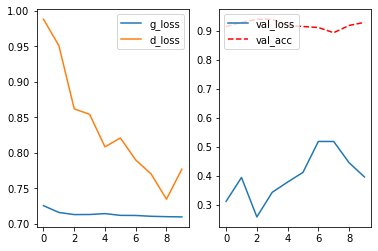

In [47]:
#Training loss
ls_g_loss = []
ls_d_loss = []
ls_val_loss = []
ls_val_acc = []

for i in range(len(training_stats)):
    ls_g_loss.append(training_stats[i]['Training Loss generator'])
    ls_d_loss.append(training_stats[i]['Training Loss discriminator'])
    ls_val_loss.append(training_stats[i]['Valid. Loss'])
    ls_val_acc.append(training_stats[i]['Valid. Accur.'])
    
#Plotting
plt.subplot(1,2,1)
plt.plot(ls_g_loss, label='g_loss')
plt.plot(ls_d_loss, label='d_loss')
plt.legend(loc='upper right')
         
plt.subplot(1,2,2)
plt.plot(ls_val_loss, label='val_loss')
plt.plot(ls_val_acc, label='val_acc', color='red', linestyle='--')
plt.legend(loc='upper left')


# Saving the models

In [48]:
t_PATH = 'model/GAN/GAN_L100_UL2k_EP10.pt'
torch.save(transformer.state_dict(), t_PATH)

d_PATH = 'model/GAN/GAN_L100_UL2k_EP10.pt'
torch.save(discriminator.state_dict(), d_PATH)

g_PATH = 'model/GAN/GAN_L100_UL2k_EP10.pt'
torch.save(generator.state_dict(), g_PATH)


# Making predictions

In [49]:
# Load 125k dataset
df_target = pd.read_csv('data/125k_without_punc.csv')
#df.columns = ['class', 'text']

# Show number of data entries
print('Number of data entries: {}'.format(len(df_target)))

# Mapping class to number
df_target['class'] = df_target['class'].map(class_map)

# label_mask
df_target['label_mask'] = df_target['class'].apply(generate_label_mask)

# Show a few samples
df_target.sample(3)

Number of data entries: 125412


,class,text,label_mask
118079,1,通独立债权团体判定组建官方委员会新浪财经讯 北京时间6月24日晚间消息国外媒体报道美国曼哈顿...,1
61117,8,纯白色乡村风格家具图纯白色乡村风格家具配合白色乡村格调家具选择鲜花作室内调色良方富肌理凹凸效...,1
79462,14,维亚康姆出售游戏业务Harmonix Music Systems新浪科技讯 北京时间12月2...,1


In [50]:
# Convert df_target to dataloader
#t0 = time.time()

input_ids, attention_mask, labels, label_masks = encode_df(df_target)
input_ids, attention_mask, labels, label_masks = concat_data(input_ids, attention_mask, labels, label_masks)
target_dataloader = make_dataloader(input_ids, attention_mask, labels, label_masks, random_sampler=False)

#print('Tokenization took time: {}'.format(format_time(time.time()-t0)))

In [51]:
prediction_stats = []

print("")
print("Running Prediction...")

t0 = time.time()

# Set models to eval mode
transformer.eval() 
discriminator.eval()
generator.eval()

# Tracking variables 
total_pred_accuracy = 0
total_pred_loss = 0

all_preds = []
all_labels_ids = []

#loss
nll_loss = torch.nn.CrossEntropyLoss(ignore_index=-1)

# Evaluate data for one epoch
for batch in target_dataloader:
    b_input_ids = batch[0].to(device)
    b_input_mask = batch[1].to(device)
    b_labels = batch[2].to(device)

    with torch.no_grad():        
        model_outputs = transformer(b_input_ids, attention_mask=b_input_mask)
        hidden_states = model_outputs[-1]
        _, logits, probs = discriminator(hidden_states)
        ###log_probs = F.log_softmax(probs[:,1:], dim=-1)
        filtered_logits = logits[:,0:-1]
        # Accumulate the test loss.
        total_pred_loss += nll_loss(filtered_logits, b_labels)

    # Accumulate the predictions and the input labels
    _, preds = torch.max(filtered_logits, 1)
    all_preds += preds.detach().cpu()
    all_labels_ids += b_labels.detach().cpu()

# Report the final accuracy for this validation run.
all_preds = torch.stack(all_preds).numpy()
all_labels_ids = torch.stack(all_labels_ids).numpy()
pred_accuracy = np.sum(all_preds == all_labels_ids) / len(all_preds)
print("  Accuracy: {0:.3f}".format(pred_accuracy))

# Calculate the average loss over all of the batches.
avg_pred_loss = total_pred_loss / len(target_dataloader)
avg_pred_loss = avg_pred_loss.item()

# Measure how long the validation run took.
pred_time = format_time(time.time() - t0)

print("  Test Loss: {0:.3f}".format(avg_pred_loss))
print("  Test took: {:}".format(pred_time))

# Record all statistics from this epoch.
print('Show experimental settings: {}'.format(dict_settings))
print('\n')

prediction_stats.append(
    {
        'Prediction. Loss': avg_pred_loss,
        'prediction. Accur.': pred_accuracy,
        'Prediction Time': pred_time,
    }
)


Running Prediction...
  Accuracy: 0.739
  Test Loss: 1.435
  Test took: 0:07:33
Show experimental settings: {'labeled_data_size': 100, 'unlabeld_data_size': 2000, 'num_train_epochs': 10}




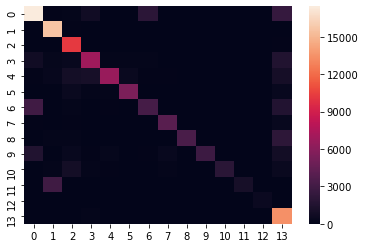

In [52]:
from sklearn.metrics import confusion_matrix, classification_report

# Confusion matrix
cm = confusion_matrix(all_preds, all_labels_ids)

sns.heatmap(cm)

In [53]:
# Classification report
cr = classification_report(all_preds, all_labels_ids)

print(cr)

              precision    recall  f1-score   support

           1       0.75      0.75      0.75     23138
           2       0.79      0.99      0.88     15838
           3       0.74      0.97      0.84     10512
           4       0.73      0.66      0.69     10386
           5       0.87      0.63      0.73     10617
           6       0.87      0.80      0.83      6907
           7       0.57      0.39      0.46      8184
           8       0.82      0.86      0.84      4674
           9       0.93      0.57      0.70      5961
          10       0.93      0.43      0.59      6490
          11       0.97      0.47      0.64      4095
          12       0.94      0.26      0.41      4122
          13       0.94      0.77      0.85       655
          14       0.55      0.97      0.70     13833

    accuracy                           0.74    125412
   macro avg       0.81      0.68      0.71    125412
weighted avg       0.77      0.74      0.73    125412



# Time took for the entire noteobok

In [54]:
time_diff = entire_notebook_t0 - time.time()
print('Time took for the entire notebook: {}'.format(time_diff))

Time took for the entire notebook: -4771.902071237564
